In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= '0.20'

from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay, precision_score, recall_score, roc_auc_score, roc_curve
from sklearn.utils import class_weight

# TensorFlow ≥2.0 is required
import tensorflow_addons as tfa
import tensorflow as tf
assert tf.__version__ >= '2.0'

from tensorflow import keras
from tensorflow.keras import layers, regularizers

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

# Common imports
import os
import glob
import numpy as np
import pandas as pd
import geopandas as gpd
import xarray as xr
import dask
import datetime
import math
import pickle
import pathlib
import hashlib
dask.config.set({'array.slicing.split_large_chunks': False})

# To make this notebook's output stable across runs
np.random.seed(42)

# Config matplotlib
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Dotenv
from dotenv import dotenv_values

# Custom utils
from utils.utils_data import *
from utils.utils_ml import *
from utils.utils_unet import *
from utils.utils_resnet import *
from utils.utils_plot import *

Num GPUs Available:  1


In [2]:
import yaml
conf = yaml.safe_load(open("config.yaml"))

In [3]:
# load data
# coordinates
lons_x = np.load('tmp/data/lons_y.npy')
lats_y = np.load('tmp/data/lats_y.npy')

times = np.arange(np.datetime64('2016-01-01'), np.datetime64('2021-12-31'))
times = pd.to_datetime(times)
# load the training and testing data
dg_train_Y_xtrm = np.array(xr.open_dataarray('tmp/data/dg_train_Y_xtrm0.95th.nc'))
dg_train_X = np.array(xr.open_dataarray('tmp/data/dg_train_X.nc'))

In [4]:
vals = dg_train_X.mean(axis=0)

In [5]:
vnames=conf['varnames']

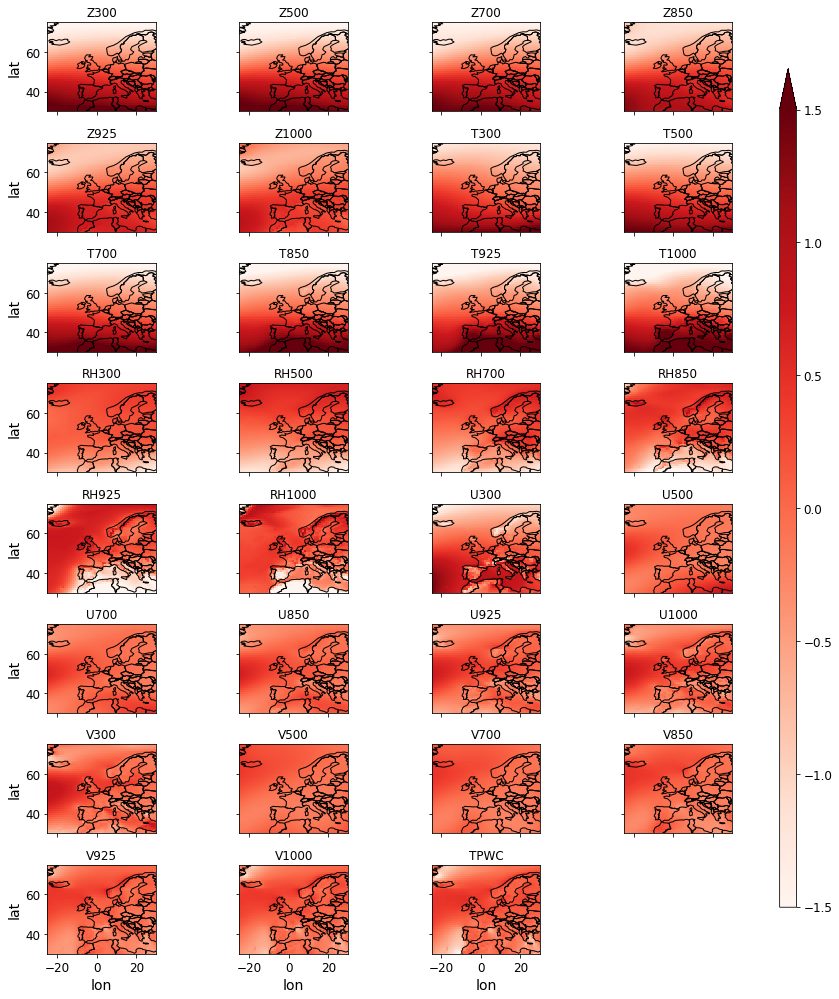

In [6]:
mx= xr.DataArray(vals, dims=["lat", "lon", "variable"],
                  coords=dict(lat = lats_y, 
            lon = lons_x, variable= conf['varnames'] ))
    
g = mx.plot.pcolormesh("lon", "lat", col="variable", col_wrap=4, robust=True, cmap='Reds',
yincrease = False, extend='max',
figsize=(14, 14),  cbar_kwargs={"orientation": "vertical", "shrink": 0.9, "aspect": 50})
    #figsize=(14, 12)
for ax, title in zip(g.axes.flat, vnames):

    world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
    world.boundary.plot(ax=ax, lw=1, color='k')
    ax.set_xlim(min(lons_x), max(lons_x))
    ax.set_title(title)
    ax.set_ylim(min(lats_y), max(lats_y))

/scratch/local/31146918/ipykernel_2997/2983964226.py:7: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d')


(-25.0, 30.0, 30.0, 75.0)

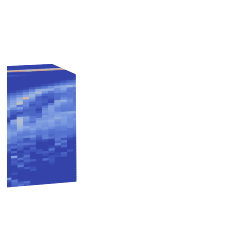

In [36]:
import numpy;
from matplotlib import pyplot
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = fig.gca(projection='3d')
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
#X, Y = np.meshgrid(lons_x, lats_y)

X, Y = np.meshgrid(lons_x, lats_y)
#Z = 50 - X

Z = np.zeros_like(X);
ax.view_init(elev=10, azim=-20)
k=1
for i in range(0,31):
    if i==0:
        ax.plot_surface(Z, X, Y, facecolors = cm.coolwarm(vals[:,:,i]))
       # 
        ax.set_xlim(min(lons_x), max(lons_x))
        ax.set_ylim(min(lats_y), max(lats_y))
        #world.boundary.plot(ax=ax)
    else:
        ax.plot_surface(Z + k , X, Y, facecolors = cm.coolwarm(vals[:,:,i]))
        k=k+1

plt.axis('off')


In [ ]:
from mpl_toolkits.basemap import Basemap
from mpl_toolkits.mplot3d import Axes3D

/scratch/local/31099842/ipykernel_31286/701408150.py:28: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d');


(-1.095, 0.9949999999999994, -1.095, 0.9949999999999994)

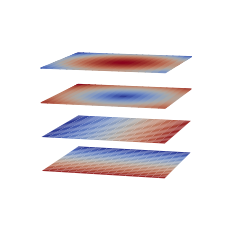

In [71]:
import numpy;
from matplotlib import pyplot;
from matplotlib import cm;
from mpl_toolkits.mplot3d import Axes3D;


# Creat mesh.
X = numpy.arange(-1, 1, 0.1);
Y = numpy.arange(-1, 1, 0.1);
X, Y = numpy.meshgrid(X, Y);

# Create some data to plot.
A = numpy.copy(X);
B = numpy.copy(Y);
C = numpy.sqrt(X**2 + Y**2);
D = numpy.cos(C);
# Normalize data for colormap use.
A -= numpy.min(A); A /= numpy.max(A);
B -= numpy.min(B); B /= numpy.max(B);
C -= numpy.min(C); C /= numpy.max(C);
D -= numpy.min(D); D /= numpy.max(D);

# Create flat surface.
Z = numpy.zeros_like(X);

# Plot
fig = pyplot.figure();
ax = fig.gca(projection='3d');
ax.view_init(10,15)
#ax.set_proj_type('ortho')
ax.plot_surface(X, Y, Z, rstride=1, cstride=1, facecolors = cm.coolwarm(A));
ax.plot_surface(X, Y, Z+0.1, rstride=1, cstride=1, facecolors = cm.coolwarm(B));
ax.plot_surface(X, Y, Z+0.2, rstride=1, cstride=1, facecolors = cm.coolwarm(C));
ax.plot_surface(X, Y, Z+0.3, rstride=1, cstride=1, facecolors = cm.coolwarm(D));

plt.axis('off')

In [140]:
np.unique(Z)

array([-5.  , -4.75, -4.5 , -4.25, -4.  , -3.75, -3.5 , -3.25, -3.  ,
       -2.75, -2.5 , -2.25, -2.  , -1.75, -1.5 , -1.25, -1.  , -0.75,
       -0.5 , -0.25,  0.  ,  0.25,  0.5 ,  0.75,  1.  ,  1.25,  1.5 ,
        1.75,  2.  ,  2.25,  2.5 ,  2.75,  3.  ,  3.25,  3.5 ,  3.75,
        4.  ,  4.25,  4.5 ,  4.75])